# 다양한 OCR모델 비교하기

- OCR 기능을 활용한 서비스를 빠르게 개발해야 하는 임무를 맡은 엔지니어라고 가정하고 어떤 모듈을 도입하면 좋을지 검토해보자.
- 컨셉은 주류 이름을 검출해내는 모델을 만드는 것이다.

In [1]:
# 모듈 import
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

## STEP 1. 검증용 데이터셋 준비

In [45]:
# 이미지 불러오기
test_filenames = tf.io.gfile.glob(str('./images/whiskey/*.jpg'))
test_filenames

['./images/whiskey/grants.jpg',
 './images/whiskey/henderson.jpg',
 './images/whiskey/jackdanniels.jpg',
 './images/whiskey/ballantine.jpg',
 './images/whiskey/macallan.jpg',
 './images/whiskey/johnniewalker.jpg',
 './images/whiskey/yamazaki.jpg',
 './images/whiskey/oldforester.jpg',
 './images/whiskey/talisker.jpg',
 './images/whiskey/glenlivet.jpg',
 './images/whiskey/makersmark.jpg',
 './images/whiskey/kavalan.jpg']

In [46]:
image_titles = []
images = []
for filename in test_filenames:
    image = cv2.imread(filename)
    images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    image_titles.append(os.path.splitext(os.path.basename(filename))[0])
image_titles

['grants',
 'henderson',
 'jackdanniels',
 'ballantine',
 'macallan',
 'johnniewalker',
 'yamazaki',
 'oldforester',
 'talisker',
 'glenlivet',
 'makersmark',
 'kavalan']

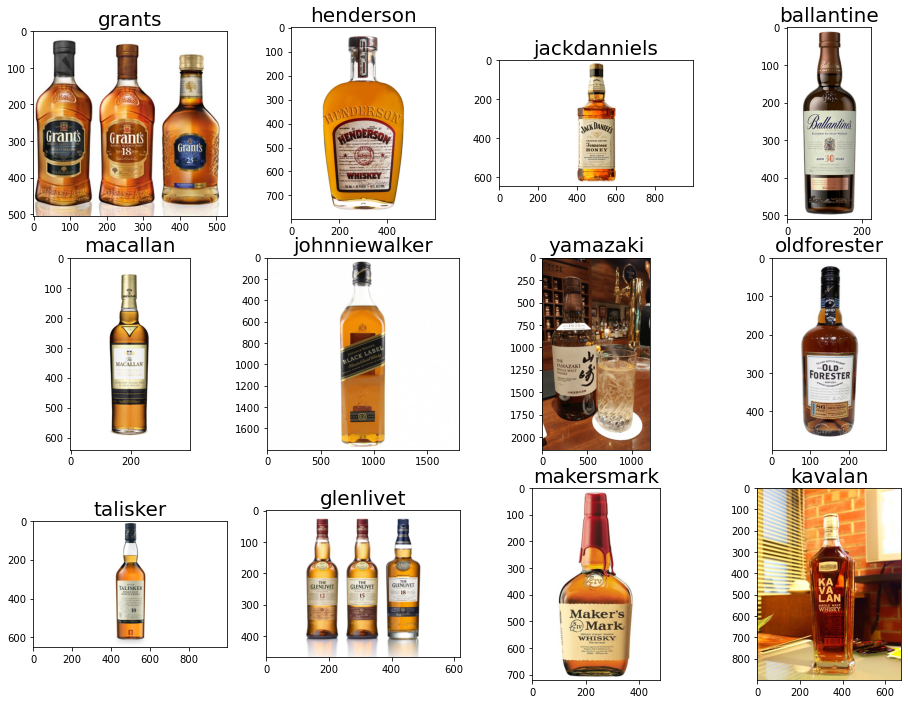

In [47]:
# 테스트 이미지 시각화
plt.figure(figsize=(16, 12))
for i, (image, title) in enumerate(zip(images, image_titles)):
    plt.subplot(3, 4, i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

## STEP 2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

### (1) Google OCR API

In [5]:
# 텍스트 탐지 함수
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [6]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

google_ocr = []

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for filenames in test_filenames:
    google_ocr.append(detect_text(filenames))

-rw-r--r-- 1 ssac10 ssac10 2352  3월 11 10:26 /home/ssac10/aiffel/ocr_python/my_google_api_key.json
Texts:

"183
Grants
Grants
Grants
RINDED SCOTCH WY
SELECT BESEHVE
18
25
VE GINERATIONS
"

"183"

"Grants"

"Grants"

"Grants"

"RINDED"

"SCOTCH"

"WY"

"SELECT"

"BESEHVE"

"18"

"25"

"VE"

"GINERATIONS"
bounds: (68,381),(114,381),(114,387),(68,387)
Texts:

"MENDERSON
HENDERSON
CT OF
71 PCmoN
al
thimar a eel te b ta al Driet
antl el phio
whe ed
Fat and stei
BLENDED
Sakm
Ofapted by ihe drgr sahal nd
WHISKEY
erity that the
750-ML* 80 PROOF * 40% ALC/VOL
750
RSON
"

"MENDERSON"

"HENDERSON"

"CT"

"OF"

"71"

"PCmoN"

"al"

"thimar"

"a"

"eel"

"te"

"b"

"ta"

"al"

"Driet"

"antl"

"el"

"phio"

"whe"

"ed"

"Fat"

"and"

"stei"

"BLENDED"

"Sakm"

"Ofapted"

"by"

"ihe"

"drgr"

"sahal"

"nd"

"WHISKEY"

"erity"

"that"

"the"

"750-ML*"

"80"

"PROOF"

"*"

"40%"

"ALC/VOL"

"750"

"RSON"
bounds: (301,96),(297,59),(307,58),(311,95)
Texts:

"Lae HONE
DANIELS
JACK
ORIGINAL RECIPE
Tennes

- 위스키의 이름, 위스키의 종류, 도수, 용량 등 각 정보를 잘 찾아낸 걸 볼 수 있다.
- 영어 뿐만 아니라 일본어도 정상적으로 잘 인식하는 것을 볼 수 있다.
- 글자의 모양이 일그러져 있어도 꽤 높은 인식률을 보여준다.
- 필기체와 같이 정자체가 아니어도 높은 인식률을 보여준다.

### (2) keras-ocr

In [7]:
import keras_ocr

pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/ssac10/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /home/ssac10/.keras-ocr/crnn_kurapan.h5


In [8]:
prediction_groups = [pipeline.recognize([filename]) for filename in test_filenames]

/home/ssac10/anaconda3/envs/aiffel/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


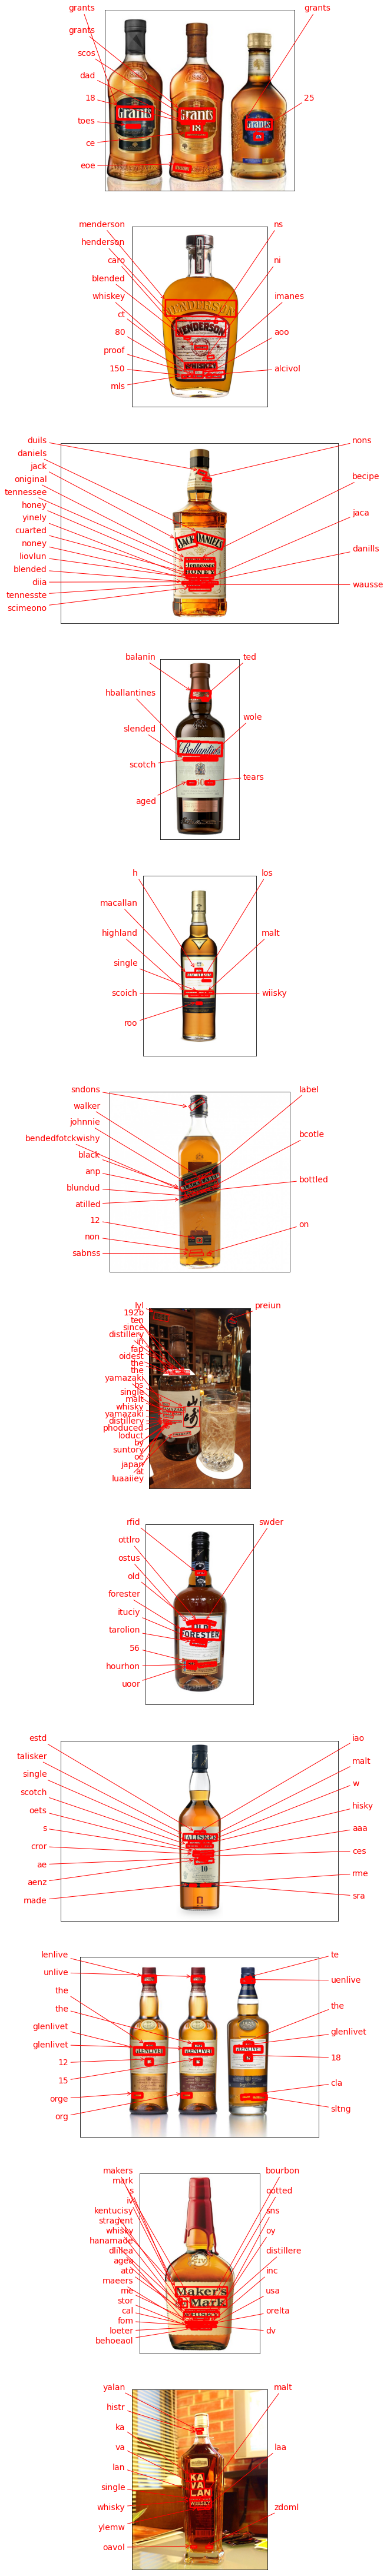

In [9]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(16, 80))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

- 위스키의 이름은 잘 인식하였으나 도수, 용량과 같은 숫자 정보는 잘 인식하지 못한 것 같다.
- 유리병에 양각으로 표시된 부분을 글자로 인식하는 경우가 있다.
- Google OCR API에 비해 시간이 오래 걸린다.

### (3) Tesseract OCR

In [10]:
import pytesseract
from PIL import Image
from pytesseract import Output

In [11]:
# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

# 이미지 영역 찾는 함수
def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [12]:
# 이미지에서 문자 인식하는 함수
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [13]:
# 각 이미지 별 폴더 생성하여 croped 이미지 얻기
for filename, title in zip(test_filenames, image_titles):
    work_dir = (os.path.join('./tesseract', title))
    os.makedirs(work_dir, exist_ok=True)
    cropped_image_path_list = crop_word_regions(filename, work_dir)
    recognize_images(cropped_image_path_list)

./tesseract/grants/0000.png
é '

Done
./tesseract/henderson/0000.png
é

Done
./tesseract/jackdanniels/0000.png

Done
./tesseract/ballantine/0000.png

Done
./tesseract/macallan/0000.png
./tesseract/macallan/0001.png
./tesseract/macallan/0002.png
Ve

MACALLAN


Done
./tesseract/johnniewalker/0000.png

Done
./tesseract/yamazaki/0000.png
./tesseract/yamazaki/0001.png
./tesseract/yamazaki/0002.png
./tesseract/yamazaki/0003.png
./tesseract/yamazaki/0004.png
./tesseract/yamazaki/0005.png
./tesseract/yamazaki/0006.png
./tesseract/yamazaki/0007.png
./tesseract/yamazaki/0008.png
./tesseract/yamazaki/0009.png
./tesseract/yamazaki/0010.png
./tesseract/yamazaki/0011.png
./tesseract/yamazaki/0012.png
./tesseract/yamazaki/0013.png
./tesseract/yamazaki/0014.png
./tesseract/yamazaki/0015.png
./tesseract/yamazaki/0016.png
./tesseract/yamazaki/0017.png
./tesseract/yamazaki/0018.png
./tesseract/yamazaki/0019.png
./tesseract/yamazaki/0020.png
./tesseract/yamazaki/0021.png
./tesseract/yamazaki/0022.

## STEP 3. 테스트 결과 정리

![result01](./images/result/result01.png)

- 결과를 한 눈에 비교해보니 Google OCR API가 가장 인식률이 높았고, 그다음 kears-ocr, tesseract는 문자를 전혀 인식하지 못했다.
- 혹시나 이미지 사이즈가 문제인가 싶어서 특정 부분만 crop하여 진행해봤음에도 불구하고 여전히 인식하지 못했다.

![result02](./images/result/result02.png)

- 그나마 tesseract가 인식한 것 중 하나를 비교해보았다. 여전히 Google OCR API는 위스키의 이름, 종류, 숫자까지 잘 인식하였다.
- 빛이 너무 강해서 문자로 인식하기 어려운 부분은 Google OCR API도 인식하진 못하였다.
- 해당 이미지의 해상도가 낮아서 사람이 보기에도 인식하기 어려운 글자를 Google OCR API는 잘 인식하였다.

![result03](./images/result/result03.png)

- Google OCI API, tesseract는 둘 다 일본어를 지원하지만 Google OCI API만 정상적으로 인식하였고, tesseract는 인식하지 못하는 모습을 보여주었다.
- kears-ocr도 일본 문자를 인식은 하지만 해당 문자를 일본어로 인식하지는 못했다.

##  STEP 4. 결과 분석과 결론 제시

- 결과는 위에서 각 이미지 별로 분석하였다.
- 결론은 Google OCR API > kears-ocr > tesseract 순으로 인식률과 정확도가 높았다.
- tesseract가 생각보다 인식률이 낮아서 의아했다. 사이즈를 조절하고 인식 위치를 바꾸어도 여전히 인식하지 못하는 문제가 있었는데 원인은 잘 모르겠다.
- 내가 구현하고자 했던 서비스의 목적은 주류의 이름, 종류, 도수, 용량 등을 인식하여 해당 주류와 비슷한 종류를 추천해주는 것이었다. 따라서 해당 술에 대한 정보를 잘 인식할 수 있어야 하므로 Google OCR API를 선택할 것이다.